### 데이터 불러오기

In [91]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from matplotlib import rcParams, font_manager

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, root_mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

In [92]:
# train, test 데이터를 불러옵니다.
path = '/Users/yniyunj/Desktop/AI/250115-EVpriceprediction'
train = pd.read_csv(path+'/open/train.csv')
test = pd.read_csv(path+'/open/test.csv')

In [93]:
# 한글 폰트 파일 경로 지정
font_path = "/Users/yniyunj/Library/Fonts/NanumGothic-Regular.ttf"  # 설치된 폰트 경로
font_prop = font_manager.FontProperties(fname=font_path)

# Matplotlib 설정
rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

print("현재 설정된 폰트:", plt.rcParams['font.family'])

현재 설정된 폰트: ['NanumGothic']


In [94]:
train.head()

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원)
0,TRAIN_0000,P사,TayGTS,Nearly New,86.077,AWD,13642,0,No,2,159.66
1,TRAIN_0001,K사,Niro,Nearly New,56.000,FWD,10199,6,No,0,28.01
2,TRAIN_0002,A사,eT,Brand New,91.200,AWD,2361,7,No,0,66.27
3,TRAIN_0003,A사,RSeTGT,Nearly New,NaN,AWD,21683,3,No,0,99.16
4,TRAIN_0004,B사,i5,Pre-Owned,61.018,AWD,178205,1,No,0,62.02


### 데이터 살펴보기

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

# 히스토그램을 여러 개 그리는 함수
def plot_histograms(data, columns_to_plot, cols=2, figsize=(15, 10)):
    rows = (len(columns_to_plot) + cols - 1) // cols  # 필요한 행 수 계산
    fig, axes = plt.subplots(rows, cols, figsize=figsize)  # 서브플롯 생성
    axes = axes.flatten()  # 2D 배열을 1D 배열로 변환

    for i, column in enumerate(columns_to_plot):
        if data[column].dtype == 'object':  # 범주형 데이터
            sns.countplot(data=data, x=column, ax=axes[i])
        else:  # 연속형 데이터
            sns.histplot(data[column], kde=True, ax=axes[i])
        axes[i].set_title(f'{column} 분포', fontsize=14)
    
    # 남은 빈 플롯 제거
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

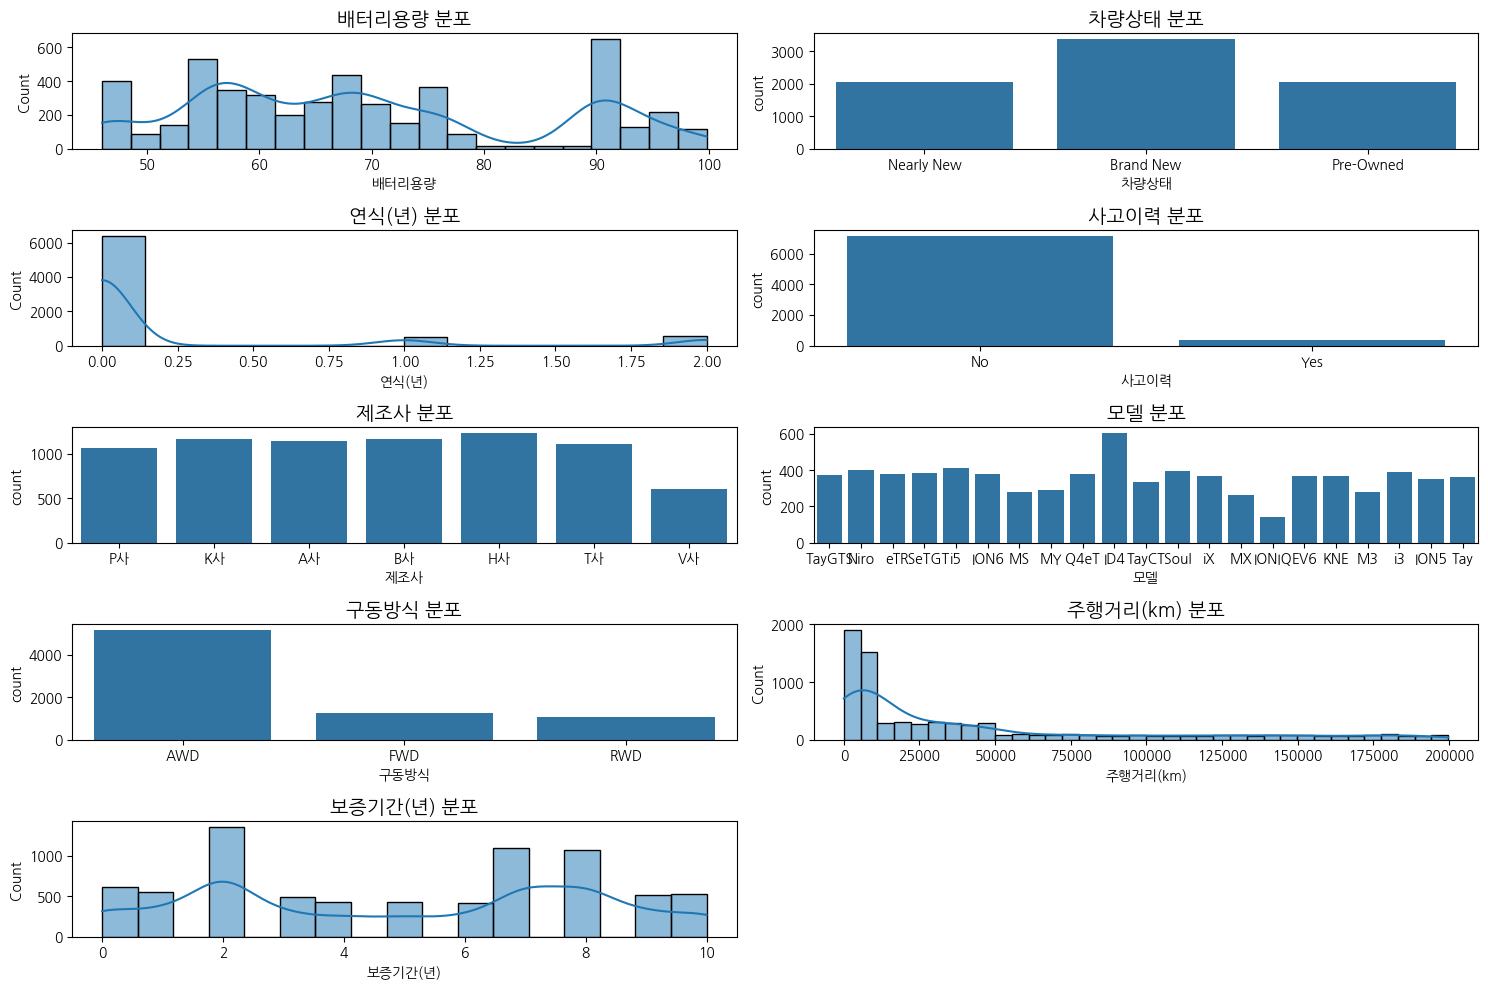

In [96]:
# 사용할 열 리스트
columns_to_plot = ['배터리용량', '차량상태', '연식(년)', '사고이력', '제조사', '모델', '구동방식', '주행거리(km)', '보증기간(년)']

# 함수 실행: 한 행에 2개씩 그래프 생성
plot_histograms(data=train, columns_to_plot=columns_to_plot, cols=2, figsize=(15, 10))

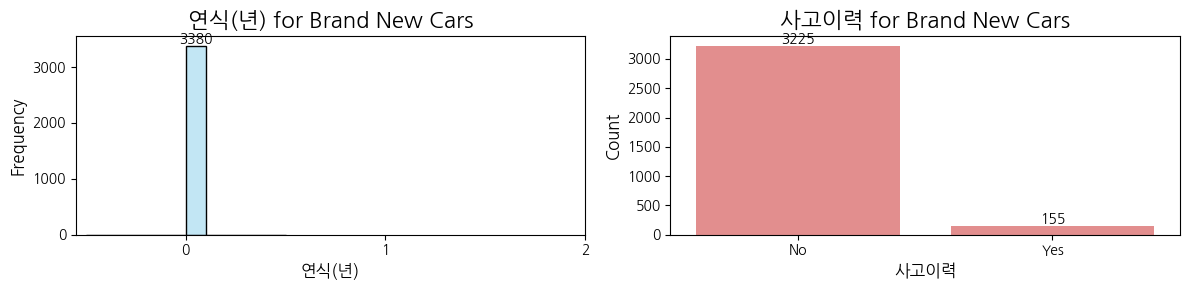

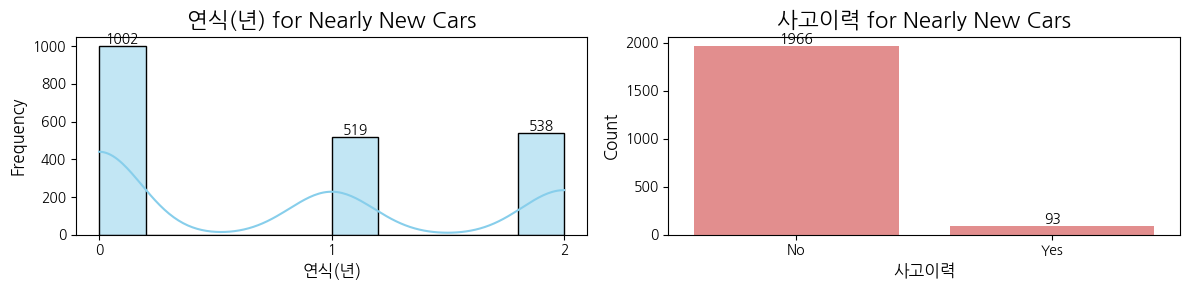

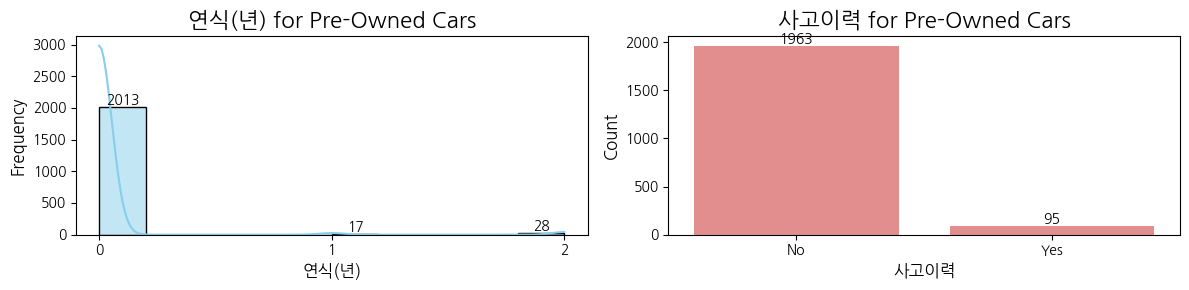

In [97]:
lst = ['Brand New', 'Nearly New', 'Pre-Owned']

for i in lst:
    # 특정 차량 상태 필터링
    brand_new_cars = train[train['차량상태'] == i]

    # 한 행에 두 개의 그래프를 표시
    fig, axes = plt.subplots(1, 2, figsize=(12, 3))  # 1행 2열 서브플롯

    # 차량의 연식 시각화
    sns.histplot(brand_new_cars['연식(년)'], kde=True, bins=10, color='skyblue', ax=axes[0])
    axes[0].set_title(f'연식(년) for {i} Cars', fontsize=16)
    axes[0].set_xlabel('연식(년)', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].set_xticks([0, 1, 2])
    # y값을 자동으로 표시
    for bar in axes[0].containers:
        labels = [f'{int(val)}' if val > 0 else '' for val in bar.datavalues]
        axes[0].bar_label(bar, labels=labels, label_type='edge', fontsize=10)

    # 차량의 사고이력 시각화
    sns.countplot(x=brand_new_cars['사고이력'], ax=axes[1], color='lightcoral')  # `color` 사용
    axes[1].set_title(f'사고이력 for {i} Cars', fontsize=16)
    axes[1].set_xlabel('사고이력', fontsize=12)
    axes[1].set_ylabel('Count', fontsize=12)
    # y값을 표시
    for bar in axes[1].containers:
        labels = [f'{int(val)}' if val > 0 else '' for val in bar.datavalues]
        axes[1].bar_label(bar, labels=labels, label_type='edge', fontsize=10)

    # 레이아웃 조정
    plt.tight_layout()
    plt.show()

### Train 데이터 중 Brand New이면서 사고이력 Yes는 무엇인가?

In [98]:
# 연식(년)이 0이고 사고이력이 있는 데이터 필터링
train_suspicious_data = train[(train['차량상태'] == 'Brand New') & (train['사고이력'] == 'Yes')]
train_suspicious_data.head()

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원)
13,TRAIN_0013,K사,Niro,Brand New,NaN,AWD,1191,10,Yes,0,21.36
116,TRAIN_0116,B사,i5,Brand New,NaN,AWD,4692,8,Yes,0,65.94
165,TRAIN_0165,H사,ION6,Brand New,NaN,AWD,1573,9,Yes,0,38.94
195,TRAIN_0195,K사,Niro,Brand New,NaN,FWD,7300,9,Yes,0,24.98
232,TRAIN_0232,B사,i3,Brand New,NaN,AWD,8648,7,Yes,0,24.38


### Test에도 Brand New이면서 사고이력이 Yes인 값들이 있나?

- 들어있음.. 이것을 어떻게 해석할 것인가
    - Brand New의 정의가 단순히 **공장에서 출고된 새 차량**이 아니라, **판매 전 차량**을 포함할 수 있음
    - 판매 전 차량은 전시, 테스트주행, 운송거리 등으로 인해서 주행거리가 기록될 수 있음

In [99]:
# 연식(년)이 0이고 사고이력이 있는 데이터 필터링
test_suspicious_data = test[(test['차량상태'] == 'Brand New') & (test['사고이력'] == 'Yes')]
test_suspicious_data.head()

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년)
2,TEST_002,B사,i5,Brand New,NaN,RWD,7197,7,Yes,0
25,TEST_025,K사,EV6,Brand New,NaN,FWD,3987,10,Yes,0
72,TEST_072,T사,MS,Brand New,99.8,AWD,1624,8,Yes,0
116,TEST_116,T사,MY,Brand New,NaN,AWD,8163,7,Yes,0
177,TEST_177,K사,EV6,Brand New,90.0,AWD,7196,10,Yes,0


In [100]:
print(train_suspicious_data['주행거리(km)'].describe())
print(test_suspicious_data['주행거리(km)'].describe())

count     155.000000
mean     4775.219355
std      3023.850266
min        30.000000
25%      1971.500000
50%      4853.000000
75%      7185.500000
max      9969.000000
Name: 주행거리(km), dtype: float64
count      21.000000
mean     5389.952381
std      2980.434507
min       563.000000
25%      3382.000000
50%      6143.000000
75%      7769.000000
max      9935.000000
Name: 주행거리(km), dtype: float64


### 새로운 파생변수(Brand New인데 사고이력이 있는 것들) 생성

- Train과 Test에 모두 이러한 데이터가 있으므로 일방적으로 삭제하는 것보다 파생변수를 생성하는 것이 좋을 것으로 판단함

In [101]:
# True면 1, False면 0
train['BrandNew_Accident'] = ((train['차량상태'] == 'Brand New') & (train['사고이력'] == 'Yes')).astype(int)
test['BrandNew_Accident'] = ((test['차량상태'] == 'Brand New') & (test['사고이력'] == 'Yes')).astype(int)

In [102]:
train.head()

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원),BrandNew_Accident
0,TRAIN_0000,P사,TayGTS,Nearly New,86.077,AWD,13642,0,No,2,159.66,0
1,TRAIN_0001,K사,Niro,Nearly New,56.000,FWD,10199,6,No,0,28.01,0
2,TRAIN_0002,A사,eT,Brand New,91.200,AWD,2361,7,No,0,66.27,0
3,TRAIN_0003,A사,RSeTGT,Nearly New,NaN,AWD,21683,3,No,0,99.16,0
4,TRAIN_0004,B사,i5,Pre-Owned,61.018,AWD,178205,1,No,0,62.02,0


### Train 레이블 인코딩

In [103]:
encoded_train = train.copy()
# 범주형 열 확인
categorical_features = [col for col in encoded_train.columns if encoded_train[col].dtype == 'object']

# 레이블 인코딩 적용
for col in categorical_features:
    le = LabelEncoder()
    le.fit(encoded_train[col])
    encoded_train[col] = le.transform(encoded_train[col])
    
# 결과 확인
print(encoded_train.head())

   ID  제조사  모델  차량상태   배터리용량  구동방식  주행거리(km)  보증기간(년)  사고이력  연식(년)  가격(백만원)  \
0   0    4  16     1  86.077     0     13642        0     0      2   159.66   
1   1    3  10     1  56.000     1     10199        6     0      0    28.01   
2   2    0  17     0  91.200     0      2361        7     0      0    66.27   
3   3    0  12     1     NaN     0     21683        3     0      0    99.16   
4   4    1  19     2  61.018     0    178205        1     0      0    62.02   

   BrandNew_Accident  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  


### Test 레이블인코딩

In [104]:
encoded_test = test.copy()
# 범주형 열 확인
categorical_features = [col for col in encoded_test.columns if encoded_test[col].dtype == 'object']

# 레이블 인코딩 적용
for col in categorical_features:
    le = LabelEncoder()
    le.fit(encoded_test[col])
    encoded_test[col] = le.transform(encoded_test[col])
    
# 결과 확인
print(encoded_test.head())

   ID  제조사  모델  차량상태   배터리용량  구동방식  주행거리(km)  보증기간(년)  사고이력  연식(년)  \
0   0    4  15     1  76.093     0     14057        2     0      0   
1   1    1  20     0  90.000     0      7547        8     0      0   
2   2    1  19     0     NaN     2      7197        7     1      0   
3   3    2   2     1  68.479     0     10357        7     0      1   
4   4    3   0     0     NaN     1      7597       10     0      0   

   BrandNew_Accident  
0                  0  
1                  0  
2                  1  
3                  0  
4                  0  


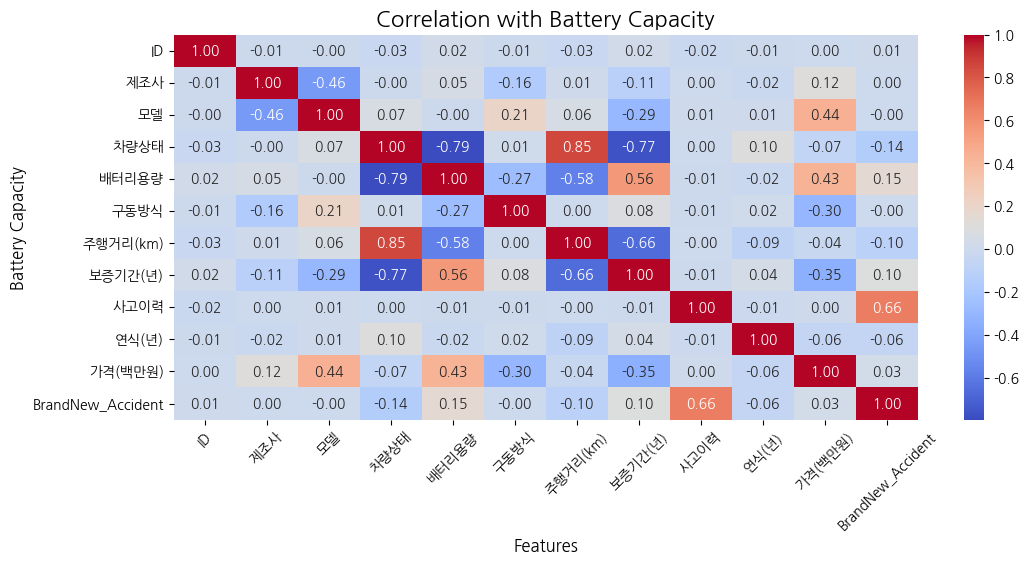

In [105]:
# '배터리용량'과 다른 변수 간의 상관계수 계산
battery_corr = encoded_train.corr()

# 상관계수 히트맵 시각화
plt.figure(figsize=(12, 5))
sns.heatmap(battery_corr.T, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation with Battery Capacity", fontsize=16)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Battery Capacity", fontsize=12)
plt.xticks(rotation=45)
plt.show()

### 결측값 채우기

- 배터리용량: 차량상태 -0.79, 주행거리(km) -0.58, 보증기간(년) 0.56
- 차량상태: 주행거리(km) 0.85, 보증기간(년) -0.77   

-> 차량상태와 보증기간(년)을 기준으로 배터리용량의 결측치를 그룹별 중앙값으로 채울거임

In [106]:
print(encoded_test['보증기간(년)'].describe())
print(encoded_test['보증기간(년)'].value_counts())

count    846.000000
mean       5.027187
std        3.157479
min        0.000000
25%        2.000000
50%        5.000000
75%        8.000000
max       10.000000
Name: 보증기간(년), dtype: float64
보증기간(년)
2     154
7     130
8     118
1      67
10     66
0      60
3      58
9      57
4      47
5      45
6      44
Name: count, dtype: int64


In [107]:
# 보증기간 구간화 및 결측치 채우기 함수
def process_data(encoded_data):
    # 보증기간(년)의 25%, 50%, 75% 계산
    quantiles = encoded_data['보증기간(년)'].quantile([0.25, 0.50, 0.75])
    q25, q50, q75 = quantiles[0.25], quantiles[0.50], quantiles[0.75]

    # 보증기간(년)을 구간화
    encoded_data['보증기간_구간'] = pd.cut(
        encoded_data['보증기간(년)'],
        bins=[-float('inf'), q25, q50, q75, float('inf')],
        labels=['25%', '50%', '75%', '100%']
    )

    # 차량상태와 보증기간 구간별 배터리용량 중앙값 계산
    median_values = encoded_data.groupby(['차량상태', '보증기간_구간'], observed=True)['배터리용량'].median().to_dict()

    # 결측치 채우기 함수
    def fill_missing_battery(row):
        if pd.isna(row['배터리용량']):
            return median_values.get((row['차량상태'], row['보증기간_구간']), row['배터리용량'])
        return row['배터리용량']

    # 결측치 채우기
    encoded_data['배터리용량'] = encoded_data.apply(fill_missing_battery, axis=1)

    return encoded_data

Train 결측치: 0
Test 결측치: 0


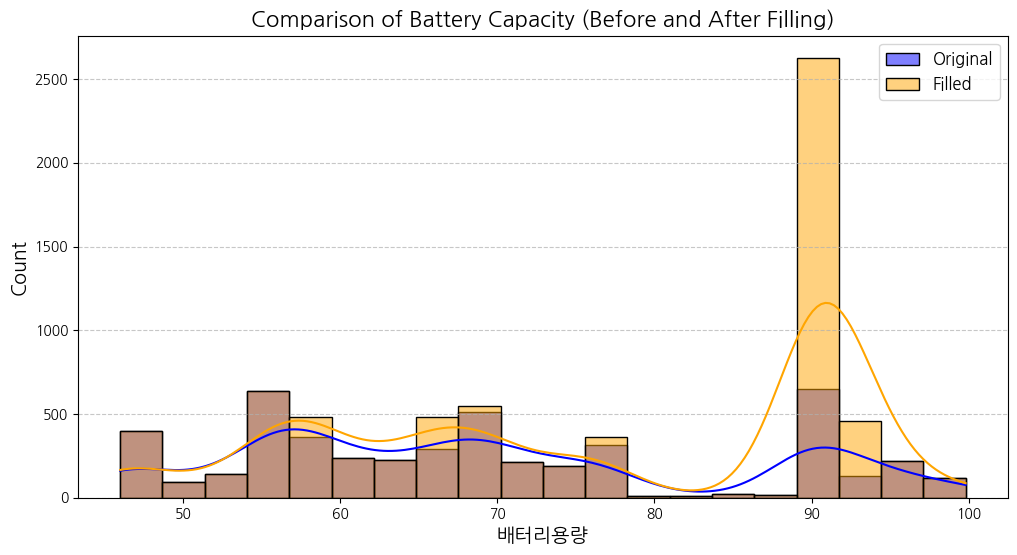

In [108]:
# 원본 데이터 복사 (결측치가 채워지기 전 데이터)
original_data = encoded_train.copy()

# 결측치 채우기
encoded_train = process_data(encoded_train)
encoded_test = process_data(encoded_test)

# 결측치 처리 결과 확인
print("Train 결측치:", encoded_train['배터리용량'].isna().sum())
print("Test 결측치:", encoded_test['배터리용량'].isna().sum())

# 그래프 비교
plt.figure(figsize=(12, 6))

# 원본 데이터의 히스토그램
sns.histplot(original_data['배터리용량'], bins=20, color='blue', kde=True, alpha=0.5, label='Original')

# 결측치 채운 데이터의 히스토그램
sns.histplot(encoded_train['배터리용량'], bins=20, color='orange', kde=True, alpha=0.5, label='Filled')

# 그래프 설정
plt.title('Comparison of Battery Capacity (Before and After Filling)', fontsize=16)
plt.xlabel('배터리용량', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [109]:
encoded_train.describe()

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원),BrandNew_Accident
count,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000
mean,3748.000000,2.746965,10.109377,0.823663,75.833935,0.452581,44287.979458,4.960918,0.045752,0.222489,62.331949,0.020675
std,2164.341817,1.885991,6.286307,0.833279,15.984889,0.728974,55204.064386,3.155342,0.208960,0.569232,36.646759,0.142303
min,0.000000,0.000000,0.000000,0.000000,46.000000,0.000000,3.000000,0.000000,0.000000,0.000000,9.000000,0.000000
25%,1874.000000,1.000000,5.000000,0.000000,61.018000,0.000000,5465.000000,2.000000,0.000000,0.000000,34.390000,0.000000
50%,3748.000000,3.000000,11.000000,1.000000,76.093000,0.000000,17331.000000,5.000000,0.000000,0.000000,56.000000,0.000000
75%,5622.000000,4.000000,16.000000,2.000000,91.200000,1.000000,61252.000000,8.000000,0.000000,0.000000,80.050000,0.000000
max,7496.000000,6.000000,20.000000,2.000000,99.800000,2.000000,199827.000000,10.000000,1.000000,2.000000,161.090000,1.000000


In [110]:
encoded_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   ID                 846 non-null    int64   
 1   제조사                846 non-null    int64   
 2   모델                 846 non-null    int64   
 3   차량상태               846 non-null    int64   
 4   배터리용량              846 non-null    float64 
 5   구동방식               846 non-null    int64   
 6   주행거리(km)           846 non-null    int64   
 7   보증기간(년)            846 non-null    int64   
 8   사고이력               846 non-null    int64   
 9   연식(년)              846 non-null    int64   
 10  BrandNew_Accident  846 non-null    int64   
 11  보증기간_구간            846 non-null    category
dtypes: category(1), float64(1), int64(10)
memory usage: 73.9 KB


### 배터리용량값 결측치 채우기

In [111]:
# 결측치 채우기
one_hot_train = train.copy()
one_hot_train = process_data(one_hot_train)
#encoded_test = process_data(encoded_test)

print("Train 결측치:", one_hot_train['배터리용량'].isna().sum())

Train 결측치: 0


In [112]:
# 결측치 채우기
one_hot_test = test.copy()
one_hot_test = process_data(one_hot_test)

print("Test 결측치:", one_hot_train['배터리용량'].isna().sum())

Test 결측치: 0


### Train 원핫 인코딩

In [113]:
# 원핫인코딩할 열 선택
columns_to_encode = ['제조사', '모델', '차량상태', '구동방식', '사고이력']  # 범주형 변수들

# 원핫인코딩 수행
one_hot_train = pd.get_dummies(one_hot_train, columns=columns_to_encode, drop_first=False)

# 원핫인코딩된 열만 0/1로 변환
one_hot_encoded_columns = [col for col in one_hot_train.columns if col.startswith(tuple(columns_to_encode))]
one_hot_train[one_hot_encoded_columns] = one_hot_train[one_hot_encoded_columns].astype(int)

# 결과 확인
print(one_hot_train.head())

print(f"원핫인코딩된 데이터의 크기: {one_hot_train.shape}")

           ID   배터리용량  주행거리(km)  보증기간(년)  연식(년)  가격(백만원)  BrandNew_Accident  \
0  TRAIN_0000  86.077     13642        0      2   159.66                  0   
1  TRAIN_0001  56.000     10199        6      0    28.01                  0   
2  TRAIN_0002  91.200      2361        7      0    66.27                  0   
3  TRAIN_0003  65.400     21683        3      0    99.16                  0   
4  TRAIN_0004  61.018    178205        1      0    62.02                  0   

  보증기간_구간  제조사_A사  제조사_B사  ...  모델_i5  모델_iX  차량상태_Brand New  차량상태_Nearly New  \
0     25%       0       0  ...      0      0               0                1   
1     75%       0       0  ...      0      0               0                1   
2     75%       1       0  ...      0      0               1                0   
3     50%       1       0  ...      0      0               0                1   
4     25%       0       1  ...      1      0               0                0   

   차량상태_Pre-Owned  구동방식_AWD  구동방식_FWD 

### Test 원핫 인코딩

In [114]:
# 원핫인코딩할 열 선택
one_hot_test = pd.get_dummies(one_hot_test, columns=columns_to_encode, drop_first=False)

# 원핫인코딩된 열만 0/1로 변환
one_hot_encoded_columns = [col for col in one_hot_test.columns if col.startswith(tuple(columns_to_encode))]
one_hot_test[one_hot_encoded_columns] = one_hot_test[one_hot_encoded_columns].astype(int)

# 결과 확인
print(one_hot_test.head())
print(f"원핫인코딩된 데이터의 크기: {one_hot_test.shape}")

         ID   배터리용량  주행거리(km)  보증기간(년)  연식(년)  BrandNew_Accident 보증기간_구간  \
0  TEST_000  76.093     14057        2      0                  0     25%   
1  TEST_001  90.000      7547        8      0                  0     75%   
2  TEST_002  95.000      7197        7      0                  1     75%   
3  TEST_003  68.479     10357        7      1                  0     75%   
4  TEST_004  90.000      7597       10      0                  0    100%   

   제조사_A사  제조사_B사  제조사_H사  ...  모델_i5  모델_iX  차량상태_Brand New  차량상태_Nearly New  \
0       0       0       0  ...      0      0               0                1   
1       0       1       0  ...      0      1               1                0   
2       0       1       0  ...      1      0               1                0   
3       0       0       1  ...      0      0               0                1   
4       0       0       0  ...      0      0               1                0   

   차량상태_Pre-Owned  구동방식_AWD  구동방식_FWD  구동방식_RWD  사고이력_No

### 상관계수 파악 (원핫인코딩해서 각 항목에 대해서 세밀하게 파악함)

In [115]:
# 상관관계 계산
one_hot_train = one_hot_train.drop(['ID','보증기간_구간'], axis=1)
correlation_matrix = one_hot_train.corr()

# 상위 상관계수 출력 (절댓값 기준으로 0.5 이상, 중복 제거)
high_corr = correlation_matrix.where(
    ~correlation_matrix.apply(lambda x: x.index > x.name)  # 상삼각 행렬만 유지
).unstack().dropna().sort_values(ascending=False)

# 절댓값 기준으로 상관관계 0.5 이상 필터링
filtered_corr = high_corr[(high_corr < 1) & (high_corr >= 0.5)]

print("중복 없이 상관계수가 0.5 이상인 변수 조합:")
print(filtered_corr)

중복 없이 상관계수가 0.5 이상인 변수 조합:
차량상태_Brand New   배터리용량                0.891646
차량상태_Pre-Owned   주행거리(km)             0.872790
제조사_P사           가격(백만원)              0.776059
차량상태_Brand New   보증기간(년)              0.675215
사고이력_Yes         BrandNew_Accident    0.663569
제조사_B사           구동방식_RWD             0.651632
보증기간(년)          배터리용량                0.629564
모델_TayGTS        가격(백만원)              0.600937
차량상태_Nearly New  연식(년)                0.596915
제조사_B사           모델_i5                0.562494
제조사_P사           모델_TayGTS            0.562070
제조사_K사           구동방식_FWD             0.555571
                 모델_Niro              0.552295
                 모델_Soul              0.551562
제조사_P사           모델_Tay               0.550937
제조사_A사           모델_RSeTGT            0.548857
                 모델_eT                0.544334
                 모델_Q4eT              0.543577
제조사_B사           모델_i3                0.543548
제조사_K사           모델_EV6               0.530710
제조사_P사           모델_TayCT        

In [116]:
# 파생변수 생성
one_hot_train['brand_new_battery'] = one_hot_train['차량상태_Brand New'] * one_hot_train['배터리용량']
one_hot_train['pre_owned_mileage'] = one_hot_train['차량상태_Pre-Owned'] * one_hot_train['주행거리(km)']
one_hot_train['brand_new_warranty'] = one_hot_train['차량상태_Brand New'] * one_hot_train['보증기간(년)']
one_hot_train['accident_repair'] = one_hot_train['사고이력_Yes'] * one_hot_train['BrandNew_Accident']
one_hot_train['manufacturer_rwd'] = one_hot_train['제조사_B사'] * one_hot_train['구동방식_RWD']
one_hot_train['warranty_per_battery'] = one_hot_train['보증기간(년)'] / (one_hot_train['배터리용량'] + 1e-5)
one_hot_train['nearly_new_year'] = one_hot_train['차량상태_Nearly New'] * one_hot_train['연식(년)']
one_hot_train['manufacturer_i5'] = one_hot_train['제조사_B사'] * one_hot_train['모델_i5']
one_hot_train['manufacturer_taygts'] = one_hot_train['제조사_P사'] * one_hot_train['모델_TayGTS']
one_hot_train['k_fwd'] = one_hot_train['제조사_K사'] * one_hot_train['구동방식_FWD']
one_hot_train['manufacturer_niro'] = one_hot_train['제조사_K사'] * one_hot_train['모델_Niro']
one_hot_train['manufacturer_soul'] = one_hot_train['제조사_K사'] * one_hot_train['모델_Soul']
one_hot_train['manufacturer_tay'] = one_hot_train['제조사_P사'] * one_hot_train['모델_Tay']
one_hot_train['manufacturer_rsetgt'] = one_hot_train['제조사_A사'] * one_hot_train['모델_RSeTGT']
one_hot_train['manufacturer_et'] = one_hot_train['제조사_A사'] * one_hot_train['모델_eT']
one_hot_train['manufacturer_q4et'] = one_hot_train['제조사_A사'] * one_hot_train['모델_Q4eT']
one_hot_train['manufacturer_i3'] = one_hot_train['제조사_B사'] * one_hot_train['모델_i3']
one_hot_train['manufacturer_ev6'] = one_hot_train['제조사_K사'] * one_hot_train['모델_EV6']
one_hot_train['manufacturer_tayct'] = one_hot_train['제조사_P사'] * one_hot_train['모델_TayCT']
one_hot_train['manufacturer_ix'] = one_hot_train['제조사_B사'] * one_hot_train['모델_iX']
one_hot_train['manufacturer_ion6'] = one_hot_train['제조사_H사'] * one_hot_train['모델_ION6']
one_hot_train['manufacturer_kne'] = one_hot_train['제조사_H사'] * one_hot_train['모델_KNE']
one_hot_train['kne_fwd'] = one_hot_train['모델_KNE'] * one_hot_train['구동방식_FWD']
one_hot_train['manufacturer_ion5'] = one_hot_train['제조사_H사'] * one_hot_train['모델_ION5']

# 결과 확인
print(one_hot_train.head())

    배터리용량  주행거리(km)  보증기간(년)  연식(년)  가격(백만원)  BrandNew_Accident  제조사_A사  \
0  86.077     13642        0      2   159.66                  0       0   
1  56.000     10199        6      0    28.01                  0       0   
2  91.200      2361        7      0    66.27                  0       1   
3  65.400     21683        3      0    99.16                  0       1   
4  61.018    178205        1      0    62.02                  0       0   

   제조사_B사  제조사_H사  제조사_K사  ...  manufacturer_et  manufacturer_q4et  \
0       0       0       0  ...                0                  0   
1       0       0       1  ...                0                  0   
2       0       0       0  ...                1                  0   
3       0       0       0  ...                0                  0   
4       1       0       0  ...                0                  0   

   manufacturer_i3  manufacturer_ev6  manufacturer_tayct  manufacturer_ix  \
0                0                 0               

### 레이블 인코딩된 test 데이터에 one-hot 에서 뽑은 파생변수 추가

In [117]:
one_hot_test = one_hot_test.drop(['ID','보증기간_구간'], axis=1)

# 파생변수 생성
one_hot_test['brand_new_battery'] = one_hot_test['차량상태_Brand New'] * one_hot_test['배터리용량']
one_hot_test['pre_owned_mileage'] = one_hot_test['차량상태_Pre-Owned'] * one_hot_test['주행거리(km)']
one_hot_test['brand_new_warranty'] = one_hot_test['차량상태_Brand New'] * one_hot_test['보증기간(년)']
one_hot_test['accident_repair'] = one_hot_test['사고이력_Yes'] * one_hot_test['BrandNew_Accident']
one_hot_test['manufacturer_rwd'] = one_hot_test['제조사_B사'] * one_hot_test['구동방식_RWD']
one_hot_test['warranty_per_battery'] = one_hot_test['보증기간(년)'] / (one_hot_test['배터리용량'] + 1e-5)
one_hot_test['nearly_new_year'] = one_hot_test['차량상태_Nearly New'] * one_hot_test['연식(년)']
one_hot_test['manufacturer_i5'] = one_hot_test['제조사_B사'] * one_hot_test['모델_i5']
one_hot_test['manufacturer_taygts'] = one_hot_test['제조사_P사'] * one_hot_test['모델_TayGTS']
one_hot_test['k_fwd'] = one_hot_test['제조사_K사'] * one_hot_test['구동방식_FWD']
one_hot_test['manufacturer_niro'] = one_hot_test['제조사_K사'] * one_hot_test['모델_Niro']
one_hot_test['manufacturer_soul'] = one_hot_test['제조사_K사'] * one_hot_test['모델_Soul']
one_hot_test['manufacturer_tay'] = one_hot_test['제조사_P사'] * one_hot_test['모델_Tay']
one_hot_test['manufacturer_rsetgt'] = one_hot_test['제조사_A사'] * one_hot_test['모델_RSeTGT']
one_hot_test['manufacturer_et'] = one_hot_test['제조사_A사'] * one_hot_test['모델_eT']
one_hot_test['manufacturer_q4et'] = one_hot_test['제조사_A사'] * one_hot_test['모델_Q4eT']
one_hot_test['manufacturer_i3'] = one_hot_test['제조사_B사'] * one_hot_test['모델_i3']
one_hot_test['manufacturer_ev6'] = one_hot_test['제조사_K사'] * one_hot_test['모델_EV6']
one_hot_test['manufacturer_tayct'] = one_hot_test['제조사_P사'] * one_hot_test['모델_TayCT']
one_hot_test['manufacturer_ix'] = one_hot_test['제조사_B사'] * one_hot_test['모델_iX']
one_hot_test['manufacturer_ion6'] = one_hot_test['제조사_H사'] * one_hot_test['모델_ION6']
one_hot_test['manufacturer_kne'] = one_hot_test['제조사_H사'] * one_hot_test['모델_KNE']
one_hot_test['kne_fwd'] = one_hot_test['모델_KNE'] * one_hot_test['구동방식_FWD']
one_hot_test['manufacturer_ion5'] = one_hot_test['제조사_H사'] * one_hot_test['모델_ION5']

# 결과 확인
print(one_hot_test.head())

    배터리용량  주행거리(km)  보증기간(년)  연식(년)  BrandNew_Accident  제조사_A사  제조사_B사  \
0  76.093     14057        2      0                  0       0       0   
1  90.000      7547        8      0                  0       0       1   
2  95.000      7197        7      0                  1       0       1   
3  68.479     10357        7      1                  0       0       0   
4  90.000      7597       10      0                  0       0       0   

   제조사_H사  제조사_K사  제조사_P사  ...  manufacturer_et  manufacturer_q4et  \
0       0       0       1  ...                0                  0   
1       0       0       0  ...                0                  0   
2       0       0       0  ...                0                  0   
3       1       0       0  ...                0                  0   
4       0       1       0  ...                0                  0   

   manufacturer_i3  manufacturer_ev6  manufacturer_tayct  manufacturer_ix  \
0                0                 0                   1 

In [118]:
print(f"train 데이터 크기: {one_hot_train.shape}")
print(f"test 데이터 크기: {one_hot_test.shape}")

train 데이터 크기: (7497, 66)
test 데이터 크기: (846, 65)


### 데이터 전처리

In [119]:
# 학습과 예측을 위해 데이터를 분리합니다.
x_train = one_hot_train.drop(['가격(백만원)'], axis = 1)
y_train = one_hot_train['가격(백만원)']

x_test = one_hot_test

### 학습 및 예측하기

In [120]:
# 사용할 모델 리스트
models = {
    "DecisionTree": DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor(),
    "GradientBoosting": GradientBoostingRegressor(),
    "LinearRegression": LinearRegression(),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor(),
    "LightGBM": LGBMRegressor(verbose=0),
    "CatBoost": CatBoostRegressor(verbose=0),  # CatBoost의 출력 제한
    "XGBoost": XGBRegressor(verbosity=0)  # XGBoost의 출력 제한
}

# RMSE를 스코어로 사용할 수 있도록 정의
rmse_scorer = make_scorer(root_mean_squared_error)

# 성능 결과를 저장할 딕셔너리
results = {}

# 반복문으로 모델 학습 및 평가 (교차 검증)
for name, model in models.items():
    print(f"Evaluating {name}...")
    # 교차 검증으로 성능 평가 (5-Fold)
    scores = cross_val_score(model, x_train, y_train, cv=5, scoring=rmse_scorer)
    results[name] = np.mean(scores)
    print(f"{name} Mean RMSE: {np.mean(scores):.4f}")

# 결과 출력
print("\n모델별 교차 검증 Mean RMSE:")
for name, rmse in results.items():
    print(f"{name}: {rmse:.4f}")

Evaluating DecisionTree...
DecisionTree Mean RMSE: 1.7861
Evaluating RandomForest...
RandomForest Mean RMSE: 1.4945
Evaluating GradientBoosting...
GradientBoosting Mean RMSE: 2.8584
Evaluating LinearRegression...
LinearRegression Mean RMSE: 3.2281
Evaluating SVR...
SVR Mean RMSE: 37.3996
Evaluating KNN...
KNN Mean RMSE: 38.3425
Evaluating LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
LightGBM Mean RMSE: 1.3555
Evaluating CatBoost...
CatBoost Mean RMSE: 1.3816
Evaluating XGBoost...
XGBoost Mean RMSE: 1.4675

모델별 교차 검증 Mean RMSE:
DecisionTree: 1.7861
RandomForest: 1.4945
GradientBoosting: 2.8584
LinearRegression: 3.2281
SVR: 37.

In [121]:
# 모델을 선언하고, 학습을 진행합니다.
model = LGBMRegressor(verbose=0)
model.fit(x_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


LGBMRegressor(verbose=0)

In [122]:
# 예측을 수행합니다.
pred = model.predict(x_test)

In [123]:
# LGBM 모델 학습 및 Feature Importance 확인
lgbm_model = LGBMRegressor()
lgbm_model.fit(x_train, y_train)
importances = pd.Series(lgbm_model.feature_importances_, index=x_train.columns)
print(importances.sort_values(ascending=False))

# Feature Importance가 0인 항목과 0이 아닌 항목 분리
zero_importance = importances[importances == 0].index.tolist()
non_zero_importance = importances[importances != 0].index.tolist()

# 결과 출력
print(f"Feature Importance가 0인 변수들: {len(zero_importance)}개")
print(zero_importance)

print(f"\nFeature Importance가 0이 아닌 변수들: {len(non_zero_importance)}개")
print(non_zero_importance)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
주행거리(km)                547
배터리용량                   490
warranty_per_battery    309
보증기간(년)                 245
pre_owned_mileage        88
                       ... 
brand_new_battery         0
사고이력_No                   0
차량상태_Brand New            0
모델_ID4                    0
manufacturer_ion5         0
Length: 65, dtype: int32
Feature Importance가 0인 변수들: 22개
['모델_ID4', '차량상태_Brand New', '사고이력_No', '사고이력_Yes', 'brand_new_battery', 'accident_repair', 'manufacturer_i5', 'manufacturer_taygts', 'manufacturer_niro', 'manufacturer_soul', 'manufacturer_tay', 'manufacturer_rsetgt', 'manufacturer_et', 'manufacturer_q4et', 'manufacturer_i3', 'manufacturer_ev6', 'manufacturer_tayct', 'manufacturer_ix', 'manufacturer_ion6', 'manufacturer_kne', 'kne_fwd', 'manufacturer_ion5']

Feature Importance가 0이 아닌 변수들: 43개
['배터리용량', '주행거리(km)', '보증기간(년)', '연식(년)', 'BrandNew_Accident', '제조사_A사', '제조사_B사', '제조사_H사', '제조사_K사', '제조사

In [124]:
print(importances[importances >=50].sort_values(ascending=False))

주행거리(km)                547
배터리용량                   490
warranty_per_battery    309
보증기간(년)                 245
pre_owned_mileage        88
모델_IONIQ                 75
연식(년)                    73
제조사_P사                   66
모델_RSeTGT                61
모델_TayGTS                60
모델_MX                    58
구동방식_AWD                 54
모델_Tay                   53
차량상태_Nearly New          52
모델_iX                    51
모델_Q4eT                  50
dtype: int32


In [125]:
print(importances[(importances < 50) & (importances >=25)].sort_values(ascending=False))

모델_M3       49
제조사_T사      47
모델_Soul     47
모델_i5       47
제조사_H사      43
모델_EV6      41
제조사_V사      40
제조사_A사      38
모델_ION5     37
제조사_B사      35
모델_Niro     35
모델_MY       32
모델_TayCT    28
모델_i3       28
제조사_K사      27
dtype: int32


In [126]:
print(importances[(importances < 25) & (importances >0)].sort_values(ascending=False))

모델_ION6               17
모델_eT                 16
모델_MS                 14
모델_KNE                12
nearly_new_year       11
BrandNew_Accident      7
구동방식_FWD               6
brand_new_warranty     4
구동방식_RWD               3
차량상태_Pre-Owned         2
manufacturer_rwd       1
k_fwd                  1
dtype: int32


주행거리(km)   
배터리용량   
보증기간(년)   
연식(년)   
모델(IONIQ, RSeTGT, TayGTS, MX, Tay, iX, Q4eT, M3, Soul, i5, EV6, ION5, Niro, MY, TayCT, i3, ION6, eT, MS, KNE)   
제조사(P사, T사, H사, V사, A사, B사, K사)   
구동방식(AWD, FWD, RWD)   
차량상태(Nearly New, Pre-Owned)   


warranty_per_battery   
pre_owned_mileage    
nearly_new_year   
BrandNew_Accident     
brand_new_warranty   
manufacturer_rwd   
k_fwd   

사고이력 제외   

### 사고이력 제외하고 warranty_per_battery와 pre_owned_mileage 추가

In [127]:
# 학습과 예측을 위해 데이터를 분리합니다.
x_train_reduced = encoded_train.drop(['ID', '사고이력', '보증기간_구간', '가격(백만원)'], axis = 1)
y_train_reduced = encoded_train['가격(백만원)']

x_test_reduced = encoded_test.drop(['ID', '사고이력', '보증기간_구간'], axis = 1)

# one_hot_train에서 필요한 열 선택
columns_to_add = ['warranty_per_battery', 'pre_owned_mileage']

# x_train_reduced에 열 추가
x_train_reduced = pd.concat([x_train_reduced, one_hot_train[columns_to_add]], axis=1)
x_test_reduced = pd.concat([x_test_reduced, one_hot_test[columns_to_add]], axis=1)


# 결과 확인
print(f"원래 x_train의 shape: {encoded_train.shape}")
print(f"x_train_reduced의 shape: {x_train_reduced.shape}")
print(f"원래 x_test의 shape: {encoded_test.shape}")
print(f"x_test_reduced의 shape: {x_test_reduced.shape}")

원래 x_train의 shape: (7497, 13)
x_train_reduced의 shape: (7497, 11)
원래 x_test의 shape: (846, 12)
x_test_reduced의 shape: (846, 11)


In [128]:
x_train_reduced

,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),연식(년),BrandNew_Accident,warranty_per_battery,pre_owned_mileage
0,4,16,1,86.077,0,13642,0,2,0,0.000000,0
1,3,10,1,56.000,1,10199,6,0,0,0.107143,0
2,0,17,0,91.200,0,2361,7,0,0,0.076754,0
3,0,12,1,65.400,0,21683,3,0,0,0.045872,0
4,1,19,2,61.018,0,178205,1,0,0,0.016389,178205
...,...,...,...,...,...,...,...,...,...,...,...
7492,2,2,0,90.000,0,3773,10,0,0,0.111111,0
7493,1,18,2,46.000,2,135411,2,0,0,0.043478,135411
7494,4,15,0,93.400,0,1363,2,0,0,0.021413,0
7495,1,18,1,56.000,2,39445,6,2,0,0.107143,0


### 학습 및 예측하기

In [129]:
# 사용할 모델 리스트
models = {
    "DecisionTree": DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor(),
    "GradientBoosting": GradientBoostingRegressor(),
    "LinearRegression": LinearRegression(),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor(),
    "LightGBM": LGBMRegressor(verbose=0),
    "CatBoost": CatBoostRegressor(verbose=0),  # CatBoost의 출력 제한
    "XGBoost": XGBRegressor(verbosity=0)  # XGBoost의 출력 제한
}

# RMSE를 스코어로 사용할 수 있도록 정의
rmse_scorer = make_scorer(root_mean_squared_error)

# 성능 결과를 저장할 딕셔너리
results = {}

# 반복문으로 모델 학습 및 평가 (교차 검증)
for name, model in models.items():
    print(f"Evaluating {name}...")
    # 교차 검증으로 성능 평가 (5-Fold)
    scores = cross_val_score(model, x_train_reduced, y_train, cv=5, scoring=rmse_scorer)
    results[name] = np.mean(scores)
    print(f"{name} Mean RMSE: {np.mean(scores):.4f}")

# 결과 출력
print("\n모델별 교차 검증 Mean RMSE:")
for name, rmse in results.items():
    print(f"{name}: {rmse:.4f}")

Evaluating DecisionTree...
DecisionTree Mean RMSE: 1.9238
Evaluating RandomForest...
RandomForest Mean RMSE: 1.5637
Evaluating GradientBoosting...
GradientBoosting Mean RMSE: 2.9357
Evaluating LinearRegression...
LinearRegression Mean RMSE: 20.8444
Evaluating SVR...
SVR Mean RMSE: 37.4092
Evaluating KNN...
KNN Mean RMSE: 37.6897
Evaluating LightGBM...
LightGBM Mean RMSE: 1.3781
Evaluating CatBoost...
CatBoost Mean RMSE: 1.3837
Evaluating XGBoost...
XGBoost Mean RMSE: 1.4641

모델별 교차 검증 Mean RMSE:
DecisionTree: 1.9238
RandomForest: 1.5637
GradientBoosting: 2.9357
LinearRegression: 20.8444
SVR: 37.4092
KNN: 37.6897
LightGBM: 1.3781
CatBoost: 1.3837
XGBoost: 1.4641


In [130]:
# 모델을 선언하고, 학습을 진행합니다.
model = LGBMRegressor(verbose=0)
model.fit(x_train_reduced, y_train)

LGBMRegressor(verbose=0)

In [131]:
# 예측을 수행합니다.
pred = model.predict(x_test_reduced)

In [132]:
# LGBM 모델 학습 및 Feature Importance 확인
lgbm_model = LGBMRegressor()
lgbm_model.fit(x_train_reduced, y_train)
importances = pd.Series(lgbm_model.feature_importances_, index=x_train_reduced.columns)
print(importances.sort_values(ascending=False))

# Feature Importance가 0인 항목과 0이 아닌 항목 분리
zero_importance = importances[importances == 0].index.tolist()
non_zero_importance = importances[importances != 0].index.tolist()

# 결과 출력
print(f"Feature Importance가 0인 변수들: {len(zero_importance)}개")
print(zero_importance)

print(f"\nFeature Importance가 0이 아닌 변수들: {len(non_zero_importance)}개")
print(non_zero_importance)

모델                      775
주행거리(km)                575
배터리용량                   371
제조사                     333
warranty_per_battery    331
보증기간(년)                 242
차량상태                    146
pre_owned_mileage       107
연식(년)                    90
구동방식                     22
BrandNew_Accident         8
dtype: int32
Feature Importance가 0인 변수들: 0개
[]

Feature Importance가 0이 아닌 변수들: 11개
['제조사', '모델', '차량상태', '배터리용량', '구동방식', '주행거리(km)', '보증기간(년)', '연식(년)', 'BrandNew_Accident', 'warranty_per_battery', 'pre_owned_mileage']


### 제출하기

In [87]:
# sample_submission 파일을 불러옵니다.
submit = pd.read_csv(path+'/open/sample_submission.csv')

# 예측한 결과를 submit에 저장합니다.
submit['가격(백만원)'] = pred
submit.head()

,ID,가격(백만원)
0,TEST_000,130.445044
1,TEST_001,80.044132
2,TEST_002,64.609686
3,TEST_003,34.988217
4,TEST_004,47.872391


In [88]:
# 제출을 위해 baseline_submission.csv란 이름으로 CSV 파일을 저장합니다.
submit.to_csv(path+'/submission/240127-pred20.csv',index=False)